   # Home Credit Default Risk(Model Tuning)

_____

The process of hyperparameter tuning (also called hyperparameter optimization) means finding the combination of hyperparameter values for a machine learning model that performs the best - as measured on a validation dataset - for a problem.

There are several approaches to hyperparameter tuning

    Manual: select hyperparameters based on intuition/experience/guessing, train the model with the hyperparameters, and score on the validation data. Repeat process until you run out of patience or are satisfied with the results.
    Grid Search: set up a grid of hyperparameter values and for each combination, train a model and score on the validation data. In this approach, every single combination of hyperparameters values is tried which can be very inefficient!
    Random search: set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.
    Automated Hyperparameter Tuning: use methods such as gradient descent, Bayesian Optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters.


### Model: Gradient Boosting Machine

The Gradient Boosting Machine (GBM) has recently emerged as one of the top machine learning models. The GBM is extremely effective on structured data - where the information is in rows and columns - and medium sized datasets - where there are at most a few million observations. We will focus on this model because it is currently the top performing method for most competitions on Kaggle and because the performance is highly dependent on the hyperparameter choices. The basics you need to know about the GBM are that it is an ensemble method that works by training many individual learners, almost always decision trees. However, unlike in a random forest where the trees are trained in parallel, in a GBM, the trees are trained sequentially with each tree learning from the mistakes of the previous ones. The hundreds or thousands of weak learners are combined to make a single strong ensemble learner with the contributions of each individual learned during training using Gradient Descent (the weights of the individual trees would therefore be a model parameter).

The GBM has many hyperparameters to tune that control both the overall ensemble (such as the learning rate) and the individual decision trees (such as the number of leaves in the tree or the maximum depth of the tree). It is difficult to know which combination of hyperparameters will work best based only on theory because there are complex interactions between hyperparameters. Hence the need for hyperparameter tuning: the only way to find the optimal hyperparameter values is to try many different combinations on a dataset!

We will use the implementation of the Gradient Boosting Machine in the LightGBM library. This is a much faster (and some say more accurate) implementation than that available in Scikit-Learn.

For more details of the Gradient Boosting Machine (GBM), check out this high-level blog post, or this in depth technical article.

---

### Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

Below we read in the data and separate into a training set of 10000 observations and a "testing set" of 6000 observations. After creating the testing set, we cannot do any hyperparameter tuning with it!

In [2]:
features = pd.read_csv('application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

We will also use only the numeric features to reduce the number of dimensions which will help speed up the hyperparameter search. Again, this is something we would not want to do on a real problem, but for demonstration purposes, it will allow us to see the concepts in practice (rather than waiting days/months for the search to finish).

In [3]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


## Cross Validation

### Example of Cross Validation and Early Stopping
To use the cv function, we first need to make a LightGBM dataset.

In [4]:
# Create a training and testing dataset

train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)



We have to pass in a set of hyperparameters to the cross validation, so we will use the default hyperparameters in LightGBM. In the cv call, the num_boost_round is set to 10,000 (num_boost_round is the same as n_estimators), but this number won't actually be reached because we are using early stopping. As a reminder, the metric we are using is Receiver Operating Characteristic Area Under the Curve (ROC AUC).

The code below carries out both cross validation with 5 folds and early stopping with 100 early stopping rounds.


In [5]:
# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

In [6]:
default_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [7]:
# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

C:\Users\AnuragMishra\Anaconda3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [8]:
cv_results

{'auc-mean': [0.6592604555298153,
  0.6688729631528496,
  0.6742292931856021,
  0.6828702105409505,
  0.691168078397955,
  0.6937215317352602,
  0.702807820668758,
  0.7023522726431334,
  0.7028406981112392,
  0.7022253391707528,
  0.7031478162852096,
  0.7027338654482691,
  0.7063401427357379,
  0.7096984863433139,
  0.7092996780478653,
  0.7104410497725376,
  0.7109090088539609,
  0.7110913457458333,
  0.7111872290409746,
  0.7105690581089128,
  0.7102333796680753,
  0.7096287425973127,
  0.7107886608257253,
  0.7119245998319378,
  0.7126609055415286],
 'auc-stdv': [0.020759130832190685,
  0.024051582833653308,
  0.024606093504957897,
  0.025878585855848638,
  0.03435225183250435,
  0.03360997776375951,
  0.025131116663319263,
  0.02520627522304095,
  0.02511106635194835,
  0.025609407148175025,
  0.026116346033670062,
  0.026813760886517702,
  0.028004478242403496,
  0.02803129039966899,
  0.027447911987064026,
  0.025849267841505808,
  0.02674807264400233,
  0.026258137097032532,
 

The cv_results is a dictionary with lists for the metric mean and the metric standard deviation. The last entry (index of -1) contains the best performing score. The length of each list in the dictionary will be the "optimal" number of estimators to train.

In [9]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.71266 with a standard deviation of 0.02191.
The optimal number of boosting rounds (estimators) was 25.


We can use this result as a baseline model to beat. To find out how well the model does on our "test" data, we will retrain it on all the training data with the best number of estimators found during cross validation with early stopping.

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.72831 ROC AUC on the test set.


This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to set the number of estimators (which by default is 100).

### Four parts of Hyperparameter tuning

It's helpful to think of hyperparameter tuning as having four parts (these four parts also will form the basis of Bayesian Optimization):

    Objective function: a function that takes in hyperparameters and returns a score we are trying to minimize or maximize
    Domain: the set of hyperparameter values over which we want to search.
    Algorithm: method for selecting the next set of hyperparameters to evaluate in the objective function.
    Results history: data structure containing each set of hyperparameters and the resulting score from the objective function.

Switching from grid to random search to Bayesian optimization will only require making minor modifications to these four parts.
###  Objective Function

The objective function takes in hyperparameters and outputs a value representing a score. Traditionally in optimization, this is a score to minimize, but here our score will be the ROC AUC which of course we want to maximize. Later, when we get to Bayesian Optimization, we will have to use a value to minimize, so we can take 1−ROC AUC

as the score. What occurs in the middle of the objective function will vary according to the problem, but for this problem, we will use cross validation with the specified model hyperparameters to get the cross-validation ROC AUC. This score will then be used to select the best model hyperparameter values.

In addition to returning the value to maximize, our objective function will return the hyperparameters and the iteration of the search. These results will let us go back and inspect what occurred during a search. The code below implements a simple objective function which we can use for both grid and random search.

In [12]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [13]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.71266.


### Domain

The domain, or search space, is all the possible values for all the hyperparameters that we want to search over. For random and grid search, the domain is a hyperparameter grid and usually takes the form of a dictionary with the keys being the hyperparameters and the values lists of values for each hyperparameter.
### Hyperparameters for GBM

To see which settings we can tune, let's make a model and print it out. You can also refer to the LightGBM documentation for the description of all the hyperparameters.


In [14]:
# Create a default model

model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Some of these we do not need to tune such as silent, objective, random_state, and n_jobs, and we will use early stopping to determine perhaps the most important hyperparameter, the number of individual learners trained, n_estimators (also referred to as num_boost_rounds or the number of iterations). Some of the hyperparameters do not need to be tuned if others are: for example, min_child_samples and min_child_weight both limit the complexity of individual decision trees by adjusting the minimum leaf observation requirements and therefore we will only adjust one. However, there are still many hyperparameters to optimize, and we will choose 10 to tune.

A complete grid for the 10 hyperparameter is defined below. Each of the values in the dicionary must be a list, so we use list combined with range, np.linspace, and np.logspace to define the range of values for each hyperparameter.

In [15]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss','dart' ],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

One aspect to note is that if boosting_type is goss, then we cannot use subsample (which refers to training on only a fraction of the rows in the training data, a technique known as stochastic gradient boosting). Therefore, we will need a line of logic in our algorithm that sets the subsample to 1.0 (which means use all the rows) if boosting_type=goss. As an example below, if we randomly select a set of hyperparameters, and the boosting type is "goss", then we set the subsample to 1.0.

In [16]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


The boosting_type and is_unbalance domains are pretty simple because these are categorical variables. For the hyperparameters that must be integers (num_leaves, min_child_samples), we use range(start, stop, [step]) which returns a range of numbers from start to stop spaced by step (or 1 if not specified). range always returns integers, which means that if we want evenly spaced values that can be fractions, we need to use np.linspace(start, stop, [num]). This works the same way except the third argument is the number of values (by default 100).

Finally, np.logspace(start, stop, [num = 100], [base = 10.0]) returns values evenly spaced on a logarithmic scale. According to the the docs "In linear space, the sequence starts at basestart
(base to the power of start) and ends with basestop " This is useful for values that differ over several orders of magnitude such as the learning rate.

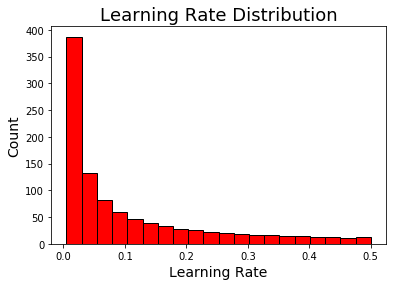

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

We can also do a sanity check to make sure the spacing is correct by counting the number of values in each interval.

In [18]:
a = 0
b = 0

# Check number of values in each category
for x in param_grid['learning_rate']:
    # Check values
    if x >= 0.005 and x < 0.05:
        a += 1
    elif x >= 0.05 and x < 0.5:
        b += 1

print('There are {} values between 0.005 and 0.05'.format(a))
print('There are {} values between 0.05 and 0.5'.format(b))

There are 499 values between 0.005 and 0.05
There are 499 values between 0.05 and 0.5


As an example of a simple domain, the num_leaves is a uniform distribution. This means values are evenly spaced on a linear scale.

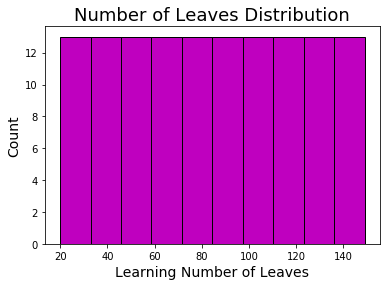

In [19]:
# number of leaves domain
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

### Algorithm for selecting next values

Although we don't generally think of them as such, both grid and random search are algorithms. In the case of grid search, we input the domain and the algorithm selects the next value for each hyperparameter in an ordered sequence. The only requirement of grid search is that it tries every combination in a grid once (and only once). For random search, we input the domain and each time the algorithm gives us a random combination of hyperparameter values to try. There are no requirements for random search other than that the next values are selected at random.

### Results History

The results history is a data structure that contains the hyperparameter combinations and the resulting score on the objective function. When we get to Bayesian Optimization, the model actually uses the past results to decide on the next hyperparmeters to evaluate. Random and grid search are uninformed methods that do not use the past history, but we still need the history so we can find out which hyperparameters worked the best!

A dataframe is a useful data structure to hold the results.

In [20]:
# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

### Grid Search Implementation

Grid search is best described as exhuastive guess and check. We have a problem: find the hyperparameters that result in the best cross validation score, and a set of values to try in the hyperparameter grid - the domain. The grid search method for finding the answer is to try all combinations of values in the domain and hope that the best combination is in the grid (in reality, we will never know if we found the best settings unless we have an infinite hyperparameter grid which would then require an infinite amount of time to run).

Grid search suffers from one limiting problem: it is extremely computationally expensive because we have to perform cross validation with every single combination of hyperparameters in the grid! Let's see how many total hyperparameter settings there are in our simple little grid we developed.


In [21]:
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 2620800000000000 combinations


In [22]:
print('This would take {:.0f} years to finish.'.format((100 * com) / (60 * 60 * 24 * 365)))

This would take 8310502283 years to finish.


The code below shows the "algorithm" for grid search. First, we unpack the values in the hyperparameter grid (which is a Python dictionary) using the line keys, values = zip(*param_grid.items()). The key line is for v in itertools.product(*values) where we iterate through all the possible combinations of values in the hyperparameter grid one at a time. For each combination of values, we create a dictionary hyperparameters = dict(zip(keys, v)) and then pass these to the objective function defined earlier. The objective function returns the cross validation score from the hyperparameters which we record in the dataframe. This process is repeated for each and every combination of hyperparameter values. By using itertools.product (from this Stack Overflow Question and Answer), we create a generator rather than allocating a list of all possible combinations which would be far too large to hold in memory.

In [23]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [24]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.72800

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 621,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


Now, since we have the best hyperparameters, we can evaluate them on our "test" data (remember not the real test data)!

In [25]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.73432 ROC AUC on the test set.


It's interesting that the model scores better on the test set than in cross validation. Usually the opposite happens (higher on cross validation than on test) because the model is tuned to the validation data. In this case, the better performance is probably due to small size of the test data and we get very lucky (although this probably does not translate to the actual competition data).

In [26]:
pd.options.display.max_colwidth = 1000
grid_results['params'].values

array([{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'n_estimators': 621},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'n_estimators': 621},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5050505050505051, 'is_unbalance': True, 'n_estimators': 621},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'co

### Random Search

Random search is surprisingly efficient compared to grid search. Although grid search will find the optimal value of hyperparameters (assuming they are in your grid) eventually, random search will usually find a "close-enough" value in far fewer iterations. This great paper explains why this is so: grid search spends too much time evaluating unpromising regions of the hyperparameter search space because it has to evaluate every single combination in the grid. Random search in contrast, does a better job of exploring the search space and therefore can usually find a good combination of hyperparameters in far fewer iterations.

In [27]:
random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'num_leaves': 88,
 'learning_rate': 0.027778881111994384,
 'subsample_for_bin': 220000,
 'min_child_samples': 175,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 1.0,
 'is_unbalance': False}

In [28]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [35]:
#param_grid

In [31]:
random_results = random_search(param_grid)

C:\Users\AnuragMishra\Anaconda3\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


KeyboardInterrupt: 

In [ ]:
print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

In [ ]:
import pprint
pprint.pprint(random_results.loc[0, 'params'])

We can also evaluate the best random search model on the "test" data.

In [ ]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

In [ ]:
random_results['params']

This time we see hyperparameter values that are all over the place, almost as if they had been selected at random! Random search will do a much better job than grid search of exploring the search domain (for the same number of iterations). If we have a limited time to evaluate hyperparameters, random search is a better option than grid search for exactly this reason.

### Stacking Random and Grid Search

One option for a smarter implementation of hyperparameter tuning is to combine random search and grid search:

    Use random search with a large hyperparameter grid
    Use the results of random search to build a focused hyperparameter grid around the best performing hyperparameter values.
    Run grid search on the reduced hyperparameter grid.
    Repeat grid search on more focused grids until maximum computational/time budget is exceeded.


Below is the code we need to run before the search. This creates the csv file, opens a connection, writes the header (column names), and then closes the connection. This will overwrite any information currently in the out_file, so change to a new file name every time you want to start a new search.

In [36]:
import csv

# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

Now we must slightly modify random_search and grid_search to write to this file every time. We do this by opening a connection, this time using the "a" option for append (the first time we used the "w" option for write) and writing a line with the desired information (which in this case is the cross validation score, the hyperparameters, and the number of the iteration). Then we close the connection until the function is called again.

In [37]:
def random_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(random_params, i)
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 

In [38]:
def grid_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(parameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

In [39]:
#To run these functions for 1000 iterations (or however many you choose) uncomment the cell below. 

In [40]:
# MAX_EVALS = 1000

# # Create file and open connection
# out_file = 'grid_search_trials_1000.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['score', 'hyperparameters', 'iteration']
# writer.writerow(headers)
# of_connection.close()

# grid_results = grid_search(param_grid, out_file)


# # Create file and open connection
# out_file = 'random_search_trials_1000.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['score', 'hyperparameters', 'iteration']
# writer.writerow(headers)
# of_connection.close()

# random_results = random_search(param_grid, out_file)


## Results on Limited Data

In [41]:
random_results = pd.read_csv('random_search_trials_1000.csv')
grid_results = pd.read_csv('grid_search_trials_1000.csv')

When we save the results to a csv, for some reason the dictionaries are saved as strings. Therefore we need to convert them back to dictionaries after reading in the results using the ast.literal_eval function.

In [42]:
import ast

# Convert strings to dictionaries
grid_results['hyperparameters'] = grid_results['hyperparameters'].map(ast.literal_eval)
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)

Now let's make a function to parse the results from the hyperparameter searches. This returns a dataframe where each column is a hyperparameter and each row has one search result (so taking the dictionary of hyperparameters and mapping it into a row in a dataframe).

In [43]:
def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df

In [44]:
grid_hyp = evaluate(grid_results, name = 'grid search')

The highest cross validation score from grid search was 0.73110 found on iteration 996.
ROC AUC from grid search on test data = 0.73242.


In [45]:
random_hyp = evaluate(random_results, name = 'random search')

The highest cross validation score from random search was 0.73448 found on iteration 596.
ROC AUC from random search on test data = 0.73069.


### Visualizations

In [46]:
# Combine results into one dataframe
random_hyp['search'] = 'random'
grid_hyp['search'] = 'grid'

hyp = random_hyp.append(grid_hyp)
hyp.head()

C:\Users\AnuragMishra\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,boosting_type,colsample_bytree,is_unbalance,iteration,learning_rate,metric,min_child_samples,n_estimators,num_leaves,reg_alpha,reg_lambda,score,search,subsample,subsample_for_bin,verbose
0,gbdt,0.644444,True,596,0.070164,auc,390,73,86,0.959184,0.673469,0.734484,random,0.530303,220000,1
1,gbdt,0.688889,False,292,0.019035,auc,360,210,146,0.061224,0.612245,0.734312,random,0.848485,240000,1
2,dart,0.600000,True,281,0.075188,auc,430,133,65,0.959184,0.489796,0.734079,random,0.757576,20000,1
3,dart,0.688889,True,349,0.055464,auc,485,375,102,0.571429,0.408163,0.734025,random,0.550505,120000,1
4,gbdt,0.600000,False,538,0.032492,auc,395,133,29,0.326531,0.061224,0.733680,random,0.898990,260000,1


In [47]:
best_grid_hyp = grid_hyp.iloc[grid_hyp['score'].idxmax()].copy()
best_random_hyp = random_hyp.iloc[random_hyp['score'].idxmax()].copy()

C:\Users\AnuragMishra\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


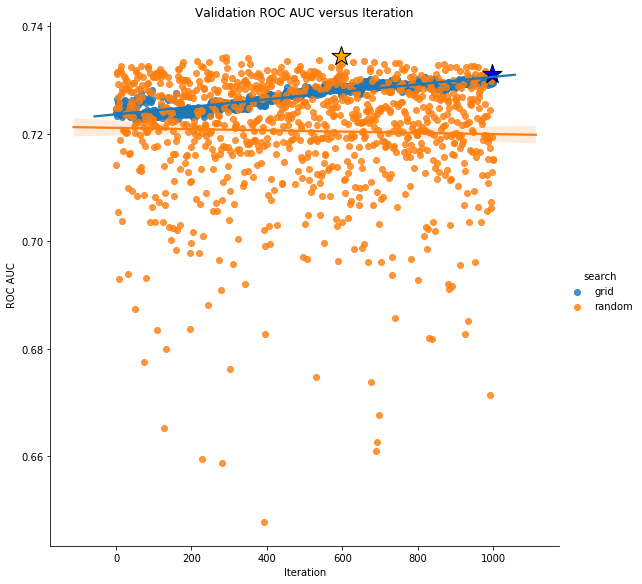

In [48]:
hyp.sort_values('search', inplace = True)

# Plot of scores over the course of searching
sns.lmplot('iteration', 'score', hue = 'search', data = hyp, size = 8);
plt.scatter(best_grid_hyp['iteration'], best_grid_hyp['score'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.scatter(best_random_hyp['iteration'], best_random_hyp['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

In [49]:
print('Average validation score of grid search =   {:.5f}.'.format(np.mean(grid_hyp['score'])))
print('Average validation score of random search = {:.5f}.'.format(np.mean(random_hyp['score'])))

Average validation score of grid search =   0.72712.
Average validation score of random search = 0.72054.


The grid cross validation score increases over time. This indicates that whatever hyperparameters are changing in grid search are gradually increasing the score. The random cross validation scores on the other hand are all over the place as expected. This grid search appears to be stuck in a relatively low-performing region of the search space, and because it is constrained to try all the values in the grid, it is not able to try significantly different hyperparameter values that would perform better (as occurs in random search). The random search method does a very good job of exploring the search space as we will see when we look at the hyperparameter values searched.

## Score versus Hyperparameters

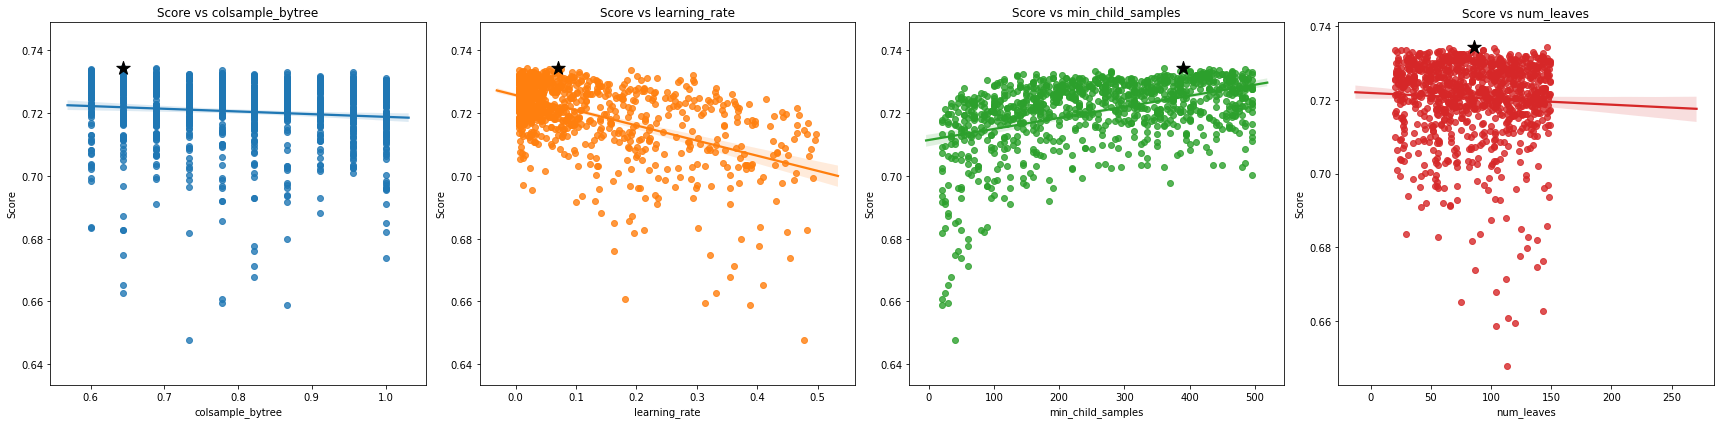

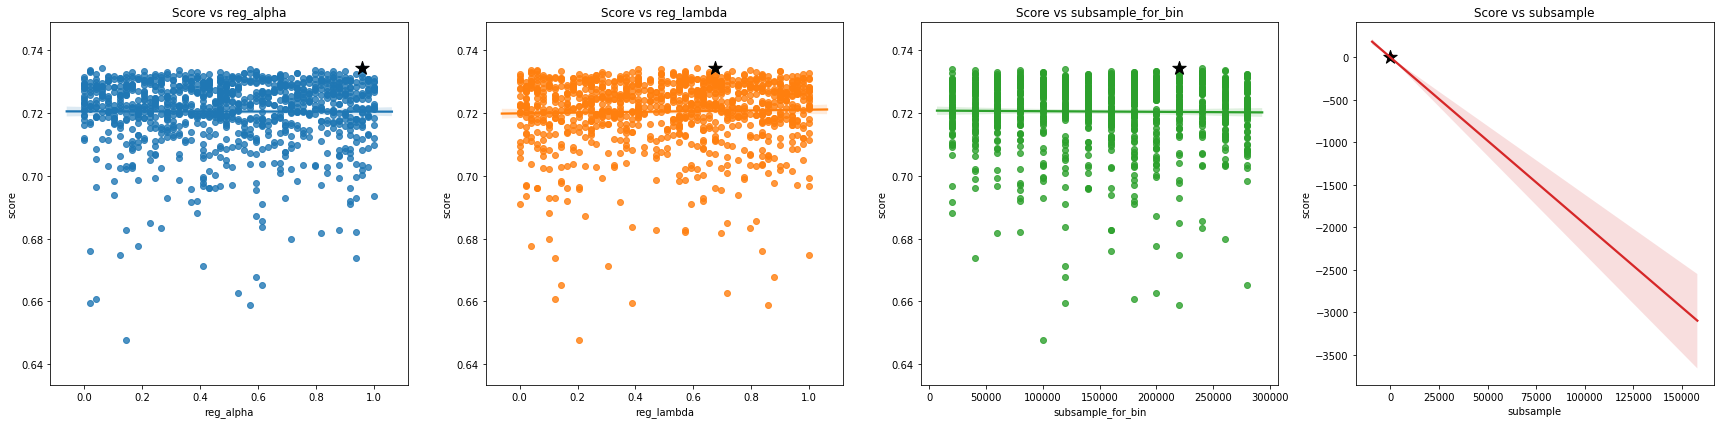

In [50]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        # Scatterplot
        sns.regplot(hyper, 'score', data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp[hyper], best_random_hyp['score'], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = '{}'.format(hyper), ylabel = 'Score', title = 'Score vs {}'.format(hyper));

plt.tight_layout()

fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next four hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
        random_hyp[hyper] = random_hyp[hyper].astype(float)
        sns.regplot(hyper, 'score', data = random_hyp, ax = axs[i])
        axs[i].scatter(best_random_hyp[hyper], best_random_hyp['score'], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = '{}'.format(hyper), ylabel = 'score', title = 'Score vs {}'.format(hyper));

plt.tight_layout()

### Testing Results on Full Data

In [51]:
# Read in full dataset
train = pd.read_csv('simple_features_train.csv')
test = pd.read_csv('simple_features_test.csv')

In [52]:

# Extract the test ids and train labels
test_ids = test['SK_ID_CURR']
train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)


Training shape:  (307507, 718)
Testing shape:  (48744, 718)


In [58]:
# to avoid json file in train
train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train.columns]
test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test.columns]

In [59]:
train_set = lgb.Dataset(train, label = train_labels)

In [60]:
hyperparameters = dict(**random_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

In [63]:
# Cross validation with n_folds and early stopping
#cv_results = lgb.cv(hyperparameters, train_set,num_boost_round = 10000, early_stopping_rounds = 100, metrics = 'auc', nfold = N_FOLDS)

First we will test the cross validation score using the best model hyperparameter values from random search. This can give us an idea of the generalization error on the test set. We will delete the number of estimators found from the smaller dataset and use early stopping to find the best number of decision trees to train.

In [64]:
print('The cross validation score on the full dataset = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

The cross validation score on the full dataset = 0.71266 with std: 0.02191.
Number of estimators = 25.


In [67]:
# Train the model with the optimal number of estimators from early stopping
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)
                        
# Predictions on the test data
#preds = model.predict_proba(test)[:, 1]

MemoryError: Unable to allocate 1.29 GiB for an array with shape (562, 307507) and data type float64

In [66]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
#submission.to_csv('submission_simple_features_random.csv', index = False)

ValueError: array length 6000 does not match index length 48744